In [815]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [816]:
flats = pd.read_csv('~/Documents/kaggle/train.csv')
flats_test = pd.read_csv('~/Documents/kaggle/test.csv')
sub = pd.read_csv('~/Documents/kaggle/sample_submission.csv')

In [817]:
full = pd.concat([flats,flats_test], axis=0)

/home/samo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


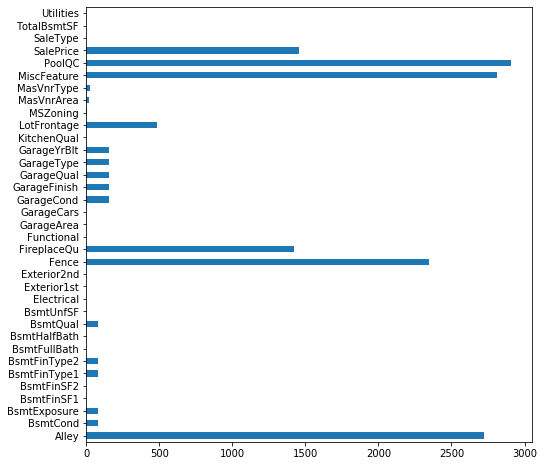

In [818]:
full_null = full.isna().sum()
plt.figure(figsize=(8,8))
full_null[full_null!=0].plot(kind='barh')

In [819]:
full_pre = full.copy()

In [820]:
full_pre.drop(['Id','Alley','PoolQC','Fence','MiscFeature'],axis=1, inplace=True)

In [821]:
num_features = full_pre.select_dtypes(exclude=['object']).columns 
full_pre[num_features] = full_pre[num_features].fillna(full[num_features].median())

In [822]:
cat_features = full_pre.select_dtypes(include=['object']).columns
#full_pre[cat_features] = full_pre[cat_features].fillna('No')

cat_features 
for cat in cat_features:
    full_pre[cat] = full_pre[cat].fillna(full_pre[cat].mode()[0])

In [823]:
full_pre.isna().any().any()

False

# Выкидываем коррелирующие с целевой фичи


In [824]:
#import numpy as np


#corr_matrix = full_pre.corr().abs()
#pper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

#full_pre.drop(to_drop, axis=1, inplace=True)

# Выкинуть все попарно коррелирующие значения

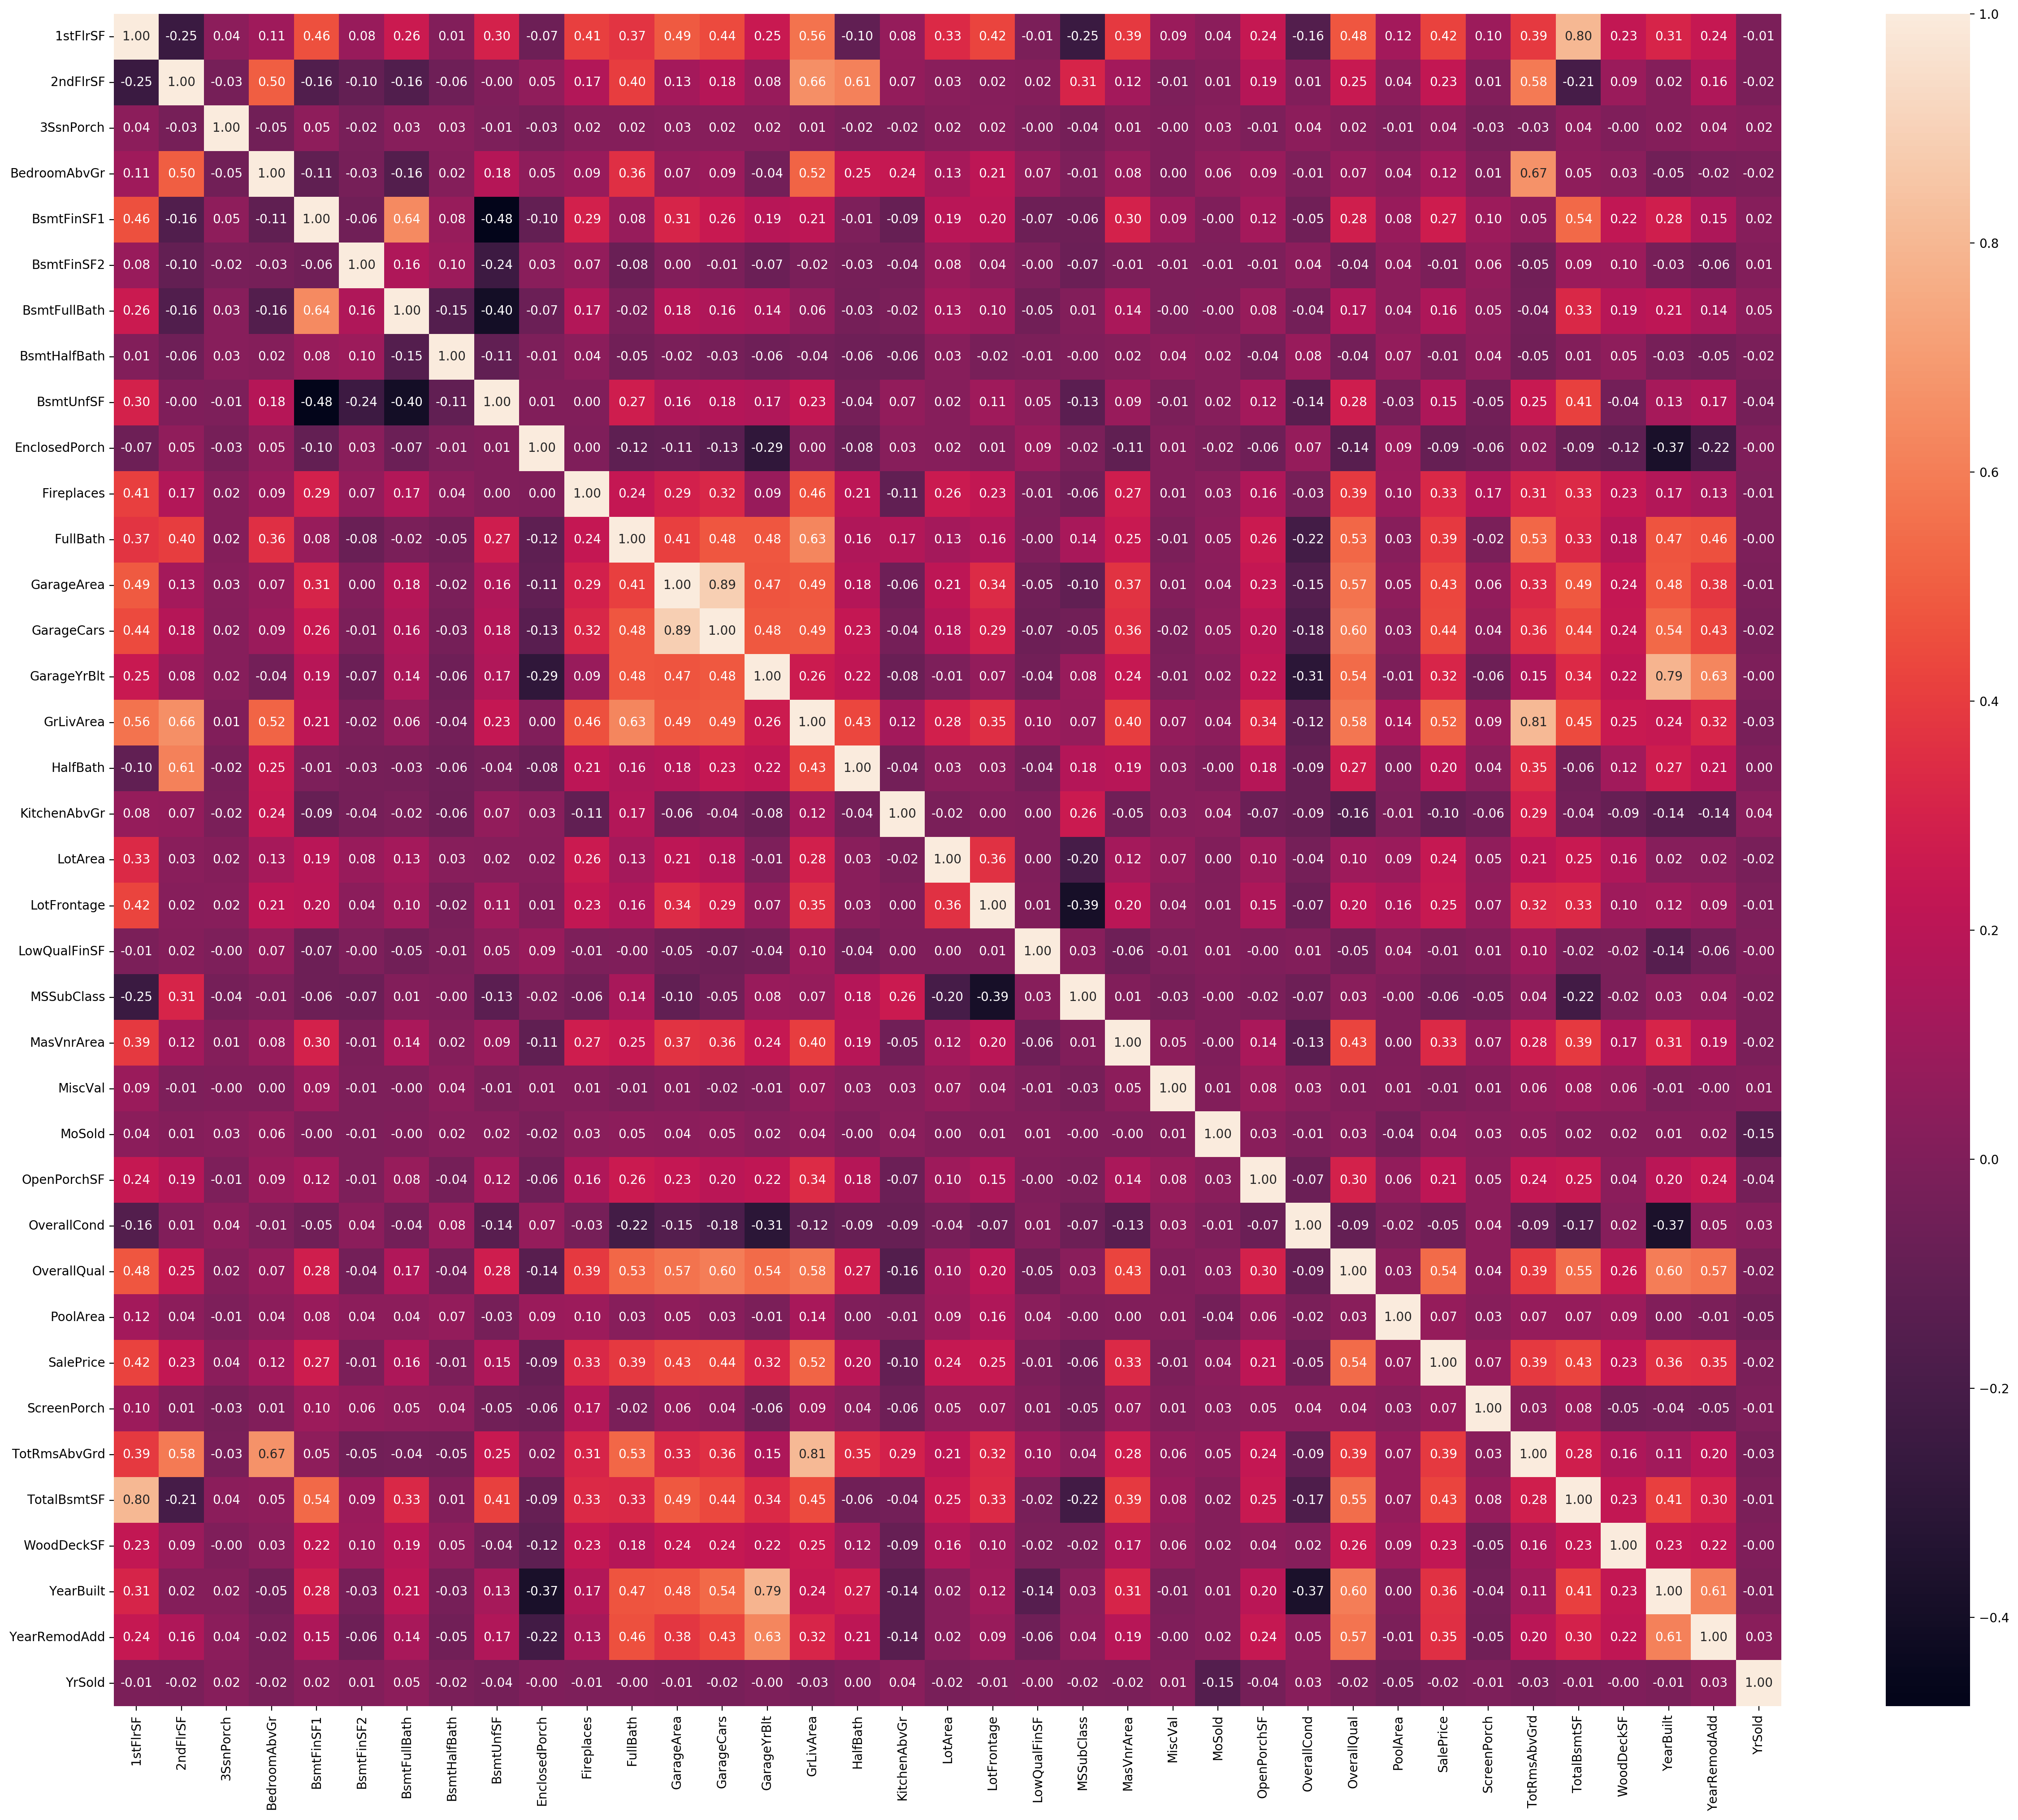

In [825]:
plt.figure(figsize=(30,25),dpi=200)
sns.heatmap(full_pre.corr(),annot=True,fmt='.2f')
plt.show()

# Выявить 10 фичей, коррелирующих с целевой 

Index(['OverallQual', 'GrLivArea'], dtype='object')


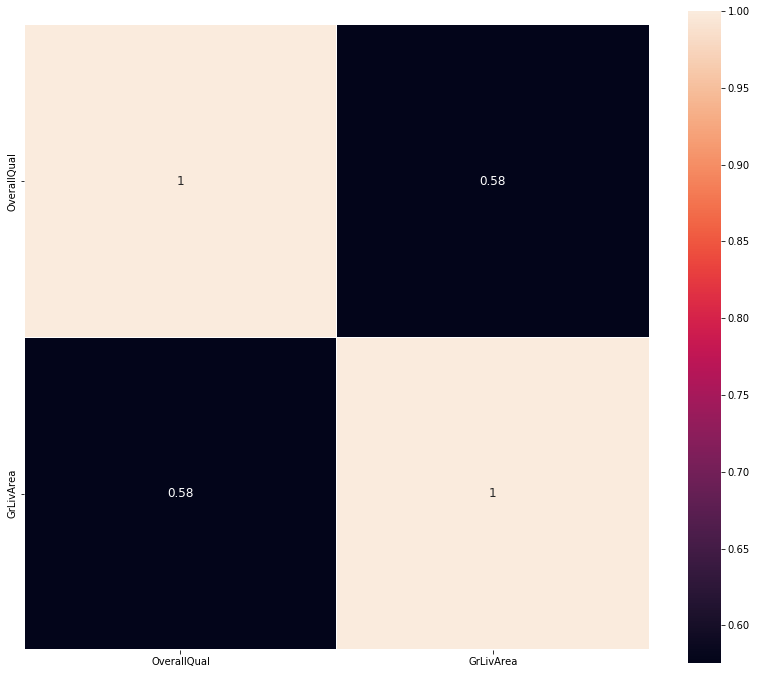

In [826]:
correlation = full_pre.corr()
k= 3
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
cols = cols.drop(['SalePrice'])
print(cols)
cm = np.corrcoef(full_pre[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, linewidths=0.01,square=True,annot=True,
            linecolor="white",xticklabels = cols.values ,
            annot_kws = {'size':12},yticklabels = cols.values)

# Начало кластеринга

In [827]:
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [828]:
X = full_pre[cols]
X = StandardScaler().fit_transform(X)

In [829]:
pca = PCA(n_components=3)
tsne = TSNE(n_components=3, perplexity=20)
umap = UMAP(n_components=3, n_neighbors=5)
X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_umap = umap.fit_transform(X)

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

Text(0.5, 1.0, 'UMAP')

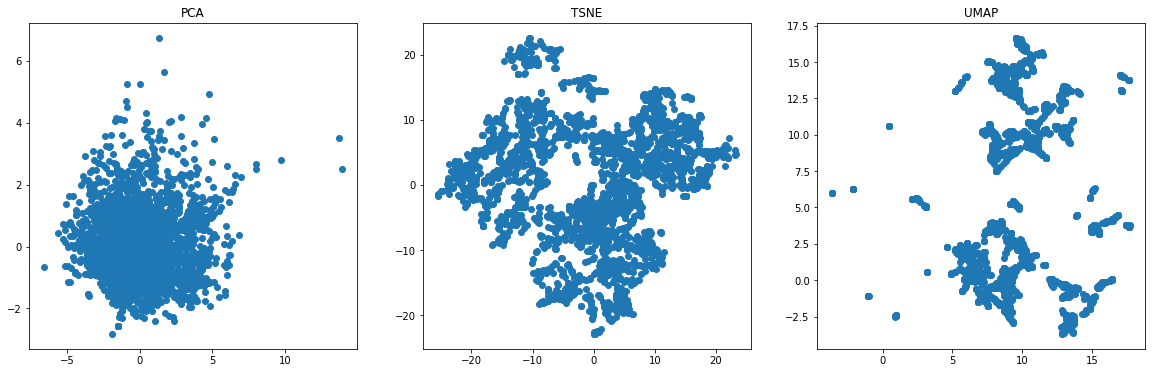

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.scatter(X_pca[:, 0], X_pca[:, 1])
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1])
ax3.scatter(X_umap[:, 0], X_umap[:, 1])

ax1.set_title('PCA')
ax2.set_title('TSNE')
ax3.set_title('UMAP')

In [ ]:
from sklearn.metrics import rand_score, jaccard_score, adjusted_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN

In [ ]:
km = KMeans(3)
ap = AffinityPropagation(max_iter=100)
dbs = DBSCAN(2)


km.fit(X_umap)
ap.fit(X_umap)
dbs.fit(X_umap)
predict = dbs.fit_predict(X_umap)

/home/samo/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,


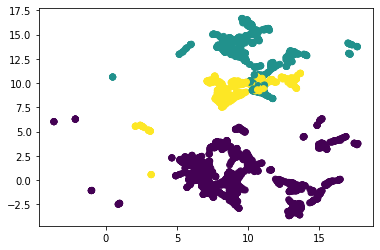

In [ ]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=km.labels_)

In [ ]:
full_pre['km_index'] = pd.Series(predict, index=full_pre.index)

In [ ]:
full_pre.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,km_index
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,0,Pave,8,856.0,AllPub,0,2003,2003,2008,0
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,0,Pave,6,1262.0,AllPub,298,1976,1976,2007,1
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,0,Pave,6,920.0,AllPub,0,2001,2002,2008,0
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,0,Pave,7,756.0,AllPub,0,1915,1970,2006,2
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,0,Pave,9,1145.0,AllPub,192,2000,2000,2008,0


# Кодирование категориальных переменных 

In [ ]:
from category_encoders import TargetEncoder
for cat in cat_features:
    encoder = TargetEncoder()
    full_pre[cat] = encoder.fit_transform(full_pre[cat], full_pre['SalePrice'])

# Логорифмирование числовых переменных со сдвигом


In [ ]:
num_features = full_pre.select_dtypes(exclude=['object']).columns 
from scipy.stats import skew 
skewness = full_pre[num_features].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

skewness = skewness[abs(skewness)>0.5]

skew_features = full_pre[skewness.index]

In [ ]:
full_pre[skew_features.columns] = np.log1p(full_pre[skew_features.columns])
full_pre[skew_features.columns]

,1stFlrSF,2ndFlrSF,3SsnPorch,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,km_index
0,6.753438,6.751101,0.0,12.069412,12.056845,12.002855,6.561031,0.0,12.199317,12.059969,...,12.247699,12.033018,0.0,12.055653,2.197225,6.753438,12.055113,0.000000,7.602900,0.000000
1,7.141245,0.000000,0.0,12.069412,12.056845,12.249963,6.886532,0.0,11.997012,12.059969,...,12.109016,12.033018,0.0,12.055653,1.945910,7.141245,12.055113,5.700444,7.589336,0.693147
2,6.825460,6.765039,0.0,12.069412,12.056845,12.085092,6.188264,0.0,12.199317,12.059969,...,12.317171,12.033018,0.0,12.055653,1.945910,6.825460,12.055113,0.000000,7.601902,0.000000
3,6.869014,6.629363,0.0,12.069412,12.154569,12.002855,5.379897,0.0,11.997012,12.059969,...,11.849405,12.033018,0.0,12.055653,2.079442,6.629363,12.055113,0.000000,7.557995,1.098612
4,7.044033,6.960348,0.0,12.069412,12.056845,12.133908,6.486161,0.0,12.199317,12.059969,...,12.429220,12.033018,0.0,12.055653,2.302585,7.044033,12.055113,5.262690,7.601402,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,6.304449,6.304449,0.0,11.924158,12.056845,12.002855,0.000000,0.0,12.009243,12.059969,...,12.001512,12.033018,0.0,12.055653,1.791759,6.304449,12.055113,0.000000,7.586296,2.302585
1455,6.304449,6.304449,0.0,12.058283,12.056845,12.002855,5.533389,0.0,11.954793,12.059969,...,12.001512,12.033018,0.0,12.055653,1.945910,6.304449,12.055113,0.000000,7.586296,2.197225
1456,7.110696,0.000000,0.0,12.069412,12.056845,12.002855,7.110696,0.0,11.997012,12.059969,...,12.001512,12.033018,0.0,12.055653,2.079442,7.110696,12.055113,6.163315,7.581210,1.098612
1457,6.878326,0.000000,0.0,12.069412,12.056845,12.133908,5.823046,0.0,12.199317,12.059969,...,12.001512,12.033018,0.0,12.055653,1.945910,6.816736,12.055113,4.394449,7.597396,2.302585


In [ ]:
full_pre.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,km_index
0,6.753438,6.751101,0.0,3,12.069412,12.056845,12.002855,6.561031,0.0,12.199317,...,0.0,12.055653,2.197225,6.753438,12.055113,0.000000,7.602900,2003,2008,0.000000
1,7.141245,0.000000,0.0,3,12.069412,12.056845,12.249963,6.886532,0.0,11.997012,...,0.0,12.055653,1.945910,7.141245,12.055113,5.700444,7.589336,1976,2007,0.693147
2,6.825460,6.765039,0.0,3,12.069412,12.056845,12.085092,6.188264,0.0,12.199317,...,0.0,12.055653,1.945910,6.825460,12.055113,0.000000,7.601902,2002,2008,0.000000
3,6.869014,6.629363,0.0,3,12.069412,12.154569,12.002855,5.379897,0.0,11.997012,...,0.0,12.055653,2.079442,6.629363,12.055113,0.000000,7.557995,1970,2006,1.098612
4,7.044033,6.960348,0.0,4,12.069412,12.056845,12.133908,6.486161,0.0,12.199317,...,0.0,12.055653,2.302585,7.044033,12.055113,5.262690,7.601402,2000,2008,0.000000


In [ ]:
#full_pre[num_features] = np.log1p(full[num_features])

In [ ]:
full_pre = pd.get_dummies(full_pre,drop_first=False)

In [ ]:
full_pre.isna().any().any()

False

# Обучение

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor

In [ ]:
y = full_pre['SalePrice'].iloc[0:1460]

In [ ]:
full_pre = full_pre.drop(['SalePrice'],axis = 1)

train = full_pre.iloc[0:1460]
test = full_pre.iloc[1460:]

In [ ]:
scoring='neg_mean_squared_error'
x_train,x_test,y_train,y_test = train_test_split(train,y.to_numpy(),random_state= 42)

In [ ]:
lr = LinearRegression()
lr.fit(x_train,y_train)

train_pre = (lr.predict(x_train))
test_pre = (lr.predict(x_test))

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.013241851720418349
test MSE: 0.016743451724121134


In [ ]:
rcv = RidgeCV()

rcv.fit(x_train, y_train)

train_pre = ((rcv.predict(x_train)))
test_pre = ((rcv.predict(x_test)))

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.013892054071903297
test MSE: 0.015499772679701724


In [ ]:
gbr = GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=200)
gbr.fit(x_train, y_train)

train_pre = gbr.predict(x_train)
test_pre = gbr.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.006801968599034226
test MSE: 0.01651327939011074


In [ ]:
import catboost
from catboost import CatBoostRegressor

In [830]:
cat = CatBoostRegressor(depth=2, learning_rate = .1, iterations=200, silent = True)
cat.fit(x_train, y_train)

train_pre = cat.predict(x_train)
test_pre = cat.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.009965137900917525
test MSE: 0.016530544167732867


In [ ]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = train, y

    classifier_name = trial.suggest_categorical("regression", ["GradientBoostingRegressor", "CatBoostRegressor"])
    if classifier_name == "GradientBoostingRegressor":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    print(study.best_trial)

[I 2021-10-22 12:12:40,701] A new study created in memory with name: no-name-3a550c22-1d1b-40d5-926c-440d40b9768a
[W 2021-10-22 12:12:40,704] Trial 0 failed because of the following error: UnboundLocalError("local variable 'y' referenced before assignment")
Traceback (most recent call last):
  File "/home/samo/anaconda3/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-659-28c88a1e191d>", line 11, in objective
    x, y = train, y
UnboundLocalError: local variable 'y' referenced before assignment


UnboundLocalError: local variable 'y' referenced before assignment

In [ ]:
def blend(x):
    return (0.5 * cat.predict(x)) + (0.5 * gbr.predict(x))
pred1 = blend(x_test)
print("test MSE:", mean_squared_error(pred1, y_test))

test MSE: 0.016023941454903254


In [ ]:
final_test_pre = blend(test)

normal_prices_arr = np.expm1(final_test_pre)
n_prices_df = pd.DataFrame(normal_prices_arr.tolist(), columns=['SalePrice'], index=range(1461, 2920)).rename_axis('Id')

In [ ]:
n_prices_df.to_csv('submission1.csv')